# Movie Reviews - Rotten Tomatoes
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.

test.tsv contains just phrases. You must assign a sentiment label to each phrase.

The sentiment labels are:

0 - negative,1 - somewhat negative,2 - neutral,3 - somewhat positive, 4 - positive

Task and Approach:
Like IMDb , Rotten Tomatoes is also one of the most popular website where people can find reviews and ratings for nearly any movie.
We need to predict the sentiment based on the each phrase by training the clasification model .

# Loading important Libraries

In [7]:
%matplotlib inline  
# To make data visualisations display in Jupyter Notebooks 
import numpy as np   # linear algebra
import pandas as pd  # Data processing, Input & Output load

import matplotlib.pyplot as plt # Visuvalization & plotting
import seaborn as sns  #Data visualisation

import nltk # Natural Language Toolkit (statistical natural language processing (NLP) libraries )
from nltk.stem.porter import *   # Stemming 

from sklearn.model_selection import train_test_split, cross_val_score
                                    # train_test_split - Split arrays or matrices into random train and test subsets
                                    # cross_val_score - Evaluate a score by cross-validation

from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier model to predict sentiment

from sklearn.feature_extraction.text import CountVectorizer #CountVectorizer converts collection of text docs to a matrix of token counts

from sklearn.feature_extraction.text import TfidfTransformer # Converting occurrences to frequencies
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings   # To avoid warning messages in the code run
warnings.filterwarnings("ignore")

In [8]:
train_MR = pd.read_csv("D:\\Data_science_project\\Data_science_project\\text_mining\\Case 1\\train.tsv",sep="\t") # Train Moview Reviews 
test_MR = pd.read_csv("D:\\Data_science_project\\Data_science_project\\text_mining\\Case 1\\test.tsv",sep="\t")

In [9]:
print('Train - ', train_MR.shape)
print('Test  - ', test_MR.shape)

Train -  (156060, 4)
Test  -  (66292, 3)


In [10]:
train_MR.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [11]:
test_MR.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [13]:
train_MR.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

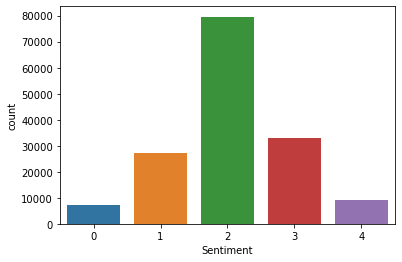

In [14]:
sns.countplot(data=train_MR,x='Sentiment')

In [15]:
dist = train_MR.groupby(["Sentiment"]).size()
print(dist)

dist_Percentage = round((dist / dist.sum())*100,2)
print(dist_Percentage)

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
dtype: int64
Sentiment
0     4.53
1    17.48
2    50.99
3    21.10
4     5.90
dtype: float64


In [16]:
train_MR['Length'] = train_MR['Phrase'].apply(lambda x: len(str(x).split(' ')))   ## Will get the length of each phrase 
test_MR['Length'] = test_MR['Phrase'].apply(lambda x: len(str(x).split(' '))) 

train_MR.head()

,PhraseId,SentenceId,Phrase,Sentiment,Length
0,1,1,A series of escapades demonstrating the adage ...,1,37
1,2,1,A series of escapades demonstrating the adage ...,2,14
2,3,1,A series,2,2
3,4,1,A,2,1
4,5,1,series,2,1


In [17]:
train_MR.isnull().sum() 

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
Length        0
dtype: int64

In [18]:
test_MR.isnull().sum() 

PhraseId      0
SentenceId    0
Phrase        0
Length        0
dtype: int64

In [19]:
train_MR['PreProcess_Sentence'] = train_MR['Phrase'].str.replace("[^a-zA-Z#]", " ")
test_MR['PreProcess_Sentence'] = test_MR['Phrase'].str.replace("[^a-zA-Z#]", " ")
train_MR.head()

,PhraseId,SentenceId,Phrase,Sentiment,Length,PreProcess_Sentence
0,1,1,A series of escapades demonstrating the adage ...,1,37,A series of escapades demonstrating the adage ...
1,2,1,A series of escapades demonstrating the adage ...,2,14,A series of escapades demonstrating the adage ...
2,3,1,A series,2,2,A series
3,4,1,A,2,1,A
4,5,1,series,2,1,series


In [20]:
train_MR['PreProcess_Sentence'] = train_MR['PreProcess_Sentence'].str.lower()
test_MR['PreProcess_Sentence'] = test_MR['PreProcess_Sentence'].str.lower()
test_MR['PreProcess_Sentence'].head()

0    an intermittently pleasing but mostly routine ...
1    an intermittently pleasing but mostly routine ...
2                                                   an
3    intermittently pleasing but mostly routine effort
4           intermittently pleasing but mostly routine
Name: PreProcess_Sentence, dtype: object

In [21]:
count_vector = CountVectorizer()
train_counts = count_vector.fit_transform(train_MR['PreProcess_Sentence'])
train_counts.shape

(156060, 15100)

In [22]:
count_vector.get_feature_names()

['aaa',
 'aaliyah',
 'aan',
 'abagnale',
 'abandon',
 'abandoned',
 'abbass',
 'abbott',
 'abbreviated',
 'abc',
 'abderrahmane',
 'abdul',
 'abel',
 'abhorrent',
 'abhors',
 'abiding',
 'abilities',
 'ability',
 'abject',
 'able',
 'ably',
 'abomination',
 'aboriginal',
 'aborted',
 'abound',
 'about',
 'above',
 'abrahams',
 'abrasive',
 'abridged',
 'abroad',
 'abrupt',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbing',
 'absorbs',
 'absorption',
 'abstract',
 'absurd',
 'absurdist',
 'absurdities',
 'absurdity',
 'absurdly',
 'abundant',
 'abundantly',
 'abuse',
 'abused',
 'abysmal',
 'abysmally',
 'abyss',
 'academic',
 'academy',
 'accent',
 'accents',
 'accentuating',
 'accept',
 'acceptable',
 'acceptance',
 'accepting',
 'accepts',
 'access',
 'accessibility',
 'accessible',
 'accident',
 'accidental',
 'acclaim',
 'acclaimed',
 'accommodate',
 'accomodates',
 'accompanied',
 'accompanies',
 'accompanying',
 'accomplish',
 'accomplished',

In [23]:
count_vector.vocabulary_.get('abdul')

11

In [24]:
## Term Frequencies (tf)
tf_transformer = TfidfTransformer(use_idf = False).fit(train_counts)  # Use fit() method to fit estimator to the data
train_tf = tf_transformer.transform(train_counts) # Use transform() method to transform count-matrix to 'tf' representation

In [25]:
## Term Frequency times Inverse Document Frequency (tf-idf)
tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(train_counts) # Use transform() method to transform count-matrix to 'tf-idf' representation

In [26]:
# Training a classifier to predict sentiment label of a phrase
# RandomForestClassifier model to predict sentiment

model = RandomForestClassifier()
Final_Model = model.fit(train_tfidf, train_MR['Sentiment'])

In [27]:
test_counts = count_vector.transform(test_MR['PreProcess_Sentence'])

# Use transform() method to transform test count-matrix to 'tf-idf' representation
test_tfidf = tfidf_transformer.transform(test_counts)
test_tfidf.shape

(66292, 15100)

In [28]:
## Prediction on test data
predicted = Final_Model.predict(test_tfidf)

In [29]:
for i, j in zip(test_MR['PhraseId'], predicted):
    print(i, predicted[j])

156061 2
156062 2
156063 2
156064 2
156065 2
156066 2
156067 2
156068 2
156069 2
156070 2
156071 2
156072 2
156073 2
156074 2
156075 2
156076 2
156077 2
156078 2
156079 2
156080 2
156081 2
156082 2
156083 2
156084 2
156085 2
156086 2
156087 2
156088 2
156089 2
156090 2
156091 2
156092 2
156093 2
156094 2
156095 2
156096 2
156097 2
156098 2
156099 2
156100 2
156101 2
156102 2
156103 2
156104 2
156105 2
156106 2
156107 2
156108 2
156109 2
156110 2
156111 2
156112 2
156113 2
156114 2
156115 2
156116 2
156117 2
156118 2
156119 2
156120 2
156121 2
156122 2
156123 2
156124 2
156125 2
156126 2
156127 2
156128 2
156129 2
156130 2
156131 2
156132 2
156133 2
156134 2
156135 2
156136 2
156137 2
156138 2
156139 2
156140 2
156141 2
156142 2
156143 2
156144 2
156145 2
156146 2
156147 2
156148 2
156149 2
156150 2
156151 2
156152 2
156153 2
156154 2
156155 2
156156 2
156157 2
156158 2
156159 2
156160 2
156161 2
156162 2
156163 2
156164 2
156165 2
156166 2
156167 2
156168 2
156169 2
156170 2
156171 2
1

In [30]:
# Writing .csv file for submission
import csv
with open('D:\\Data_science_project\\Data_science_project\\text_mining\Case 2\\Movie_Sentiment.csv', 'w') as csvfile:
    csvfile.write('PhraseId,Sentiment\n')
    for i, j in zip(test_MR['PhraseId'], predicted):
         csvfile.write('{}, {}\n'.format(i, j))

# End of Notebook